In [1]:
import numpy as np

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import Dataset

class CustomMNIST(Dataset):
    def __init__(self, image, labels):
        self.labels = labels
        self.image = image
 
    def __len__(self):
        return len(self.labels)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        label = self.labels[idx]
        image = self.image[idx]/255
        
        # sample = {"inputs": image, "label": label}
        return image, label

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('Available device: {}'.format(device))
torch.backends.cudnn.benchmark = True

Available device: cuda:0


In [4]:
train_dataset = torchvision.datasets.MNIST(
    root='data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

X_train_task_original = train_dataset.data.view(-1, 784)
# X_train_task_B = train_dataset.data.transpose(1, 2).reshape(-1, 784)
# print(X_train_task_B.shape)
# print(X_train_task_original.shape)

y_train = train_dataset.targets

In [5]:
test_dataset = torchvision.datasets.MNIST(
    root='data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)

# X_test = test_dataset.data.view(-1, 784)
# y_test = test_dataset.targets.view(-1, 1)

X_test_task_original = test_dataset.data.view(-1, 784)
# X_test_task_B = test_dataset.data.transpose(1, 2).reshape(-1, 784)
# print(X_test_task_B.shape)
# print(X_test_task_A.shape)

y_test = test_dataset.targets

In [6]:
X_train = []
X_train.append(CustomMNIST(X_train_task_original, y_train))
X_test = []
X_test.append(CustomMNIST(X_test_task_original, y_test))
n_tasks = 10

for task in range(n_tasks-1):
    permutation = np.random.permutation(784)
    X_train_task = torch.empty(X_train_task_original.shape[0], 784)
    X_test_task = torch.empty(X_test_task_original.shape[0], 784)
    for i in range(X_train_task_original.shape[0]):
        
        X_train_task[i] = torch.unsqueeze(X_train_task_original[i][permutation], 0)
        # print(X_train_task.shape)
        # break
    for i in range(X_test_task_original.shape[0]):
        # X_train_task = torch.cat((X_test_task, torch.unsqueeze(X_test_task_original[i][permutation], 0)), 0)
        X_test_task[i] = torch.unsqueeze(X_test_task_original[i][permutation], 0)
        # X_test_task.append(X_test_task_original[i][permutation])
    X_train.append(CustomMNIST(X_train_task, y_train))
    X_test.append(CustomMNIST(X_test_task, y_test))

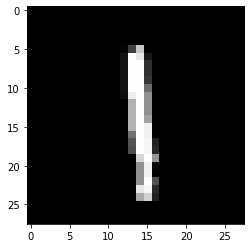

In [7]:
# print(X_train[1][0][0])
img = X_train[0][8][0].reshape(28,28) * 255
img = img.numpy()
plt.imshow(img, cmap='gray')

In [8]:
model = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 400),
    nn.ReLU(),
    nn.Linear(400, 10)
)

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [10]:
train_loaders = [torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=128*4,
    shuffle=True,
) for dataset in X_train]

test_loaders = [torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=128*4,
    shuffle=True,
) for dataset in X_test]

In [11]:
def train_tasks(train_loader, test_loaders, n_epoch, current_epoch, test_accuracies):
    for it in range(current_epoch, current_epoch + n_epoch):
        
        # epoch_train_losses = []
        # epoch_test_losses = []
        
        n_correct_train = 0
        n_total_train = 0
        
        for (inputs, labels) in train_loader:
            inputs, labels = inputs.to(device).view(-1, 784), labels.to(device)
            
            # inputs = inputs.view(-1, 784)        
            outputs = model(inputs)
            
            optimizer.zero_grad()
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            # epoch_train_losses.append(loss.item())
            
            _, predictions = torch.max(outputs, 1)
            n_correct_train += (predictions == labels).sum().item()
            n_total_train += labels.shape[0]

        # train_accuracy[it] = n_correct_train/n_total_train
        # train_losses[it] = np.mean(epoch_train_losses)
            
        for (task_number, test_loader) in enumerate(test_loaders):
            n_correct_test = 0
            n_total_test = 0
            for (inputs, labels) in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # print(labels.shape[0])
                
                inputs = inputs.view(-1, 784)
                outputs = model(inputs)
                
                # loss = criterion(outputs, labels)
                
                # epoch_test_losses.append(loss.item())
                
                _, predictions = torch.max(outputs, 1)
                n_correct_test += (predictions == labels).sum().item()
                n_total_test += labels.shape[0]
                
            # print(n_correct_test)
            # break
            test_accuracies[task_number][it] = n_correct_test/n_total_test

        print('Epoch {}/{}'.format(it+1, n_epoch * n_tasks))

In [12]:
n_epoch = 20
current_epoch = 0

# train_losses = np.zeros(n_epoch_A + n_epoch_B)
# test_losses = np.zeros(n_epoch_A + n_epoch_B)
# train_accuracy = np.zeros(n_epoch_A + n_epoch_B)
# test_losses[it] = np.mean(epoch_test_losses)
test_accuracies = np.zeros((n_tasks, n_epoch * n_tasks))
print(test_accuracies.shape)

for (i, train_loader) in enumerate(train_loaders):
    print('Training task {}/{}'.format(i+1, n_tasks))
    train_tasks(train_loader, test_loaders, n_epoch, current_epoch, test_accuracies)
    current_epoch += n_epoch

(10, 200)
Training task 1/10
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Training task 2/10
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Training task 3/10
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Training task 4/10
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200


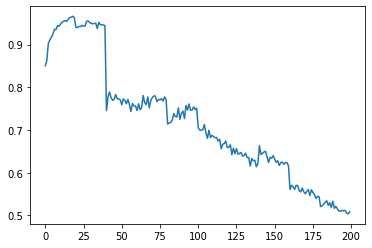

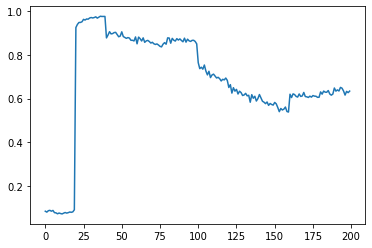

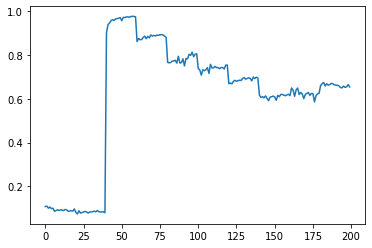

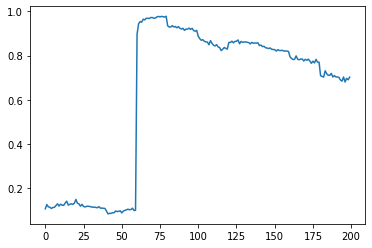

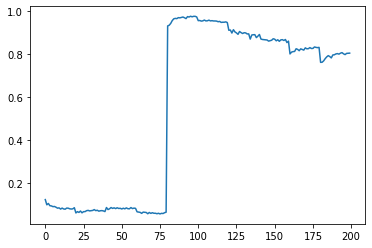

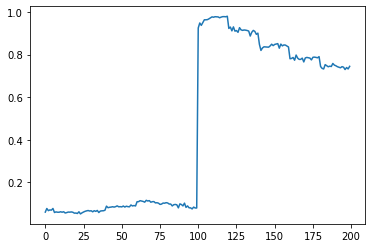

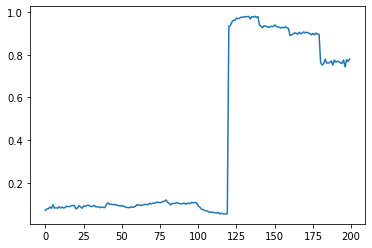

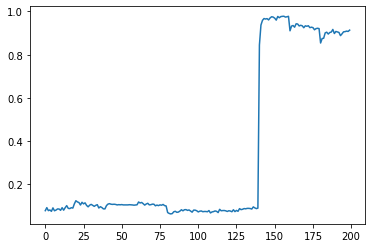

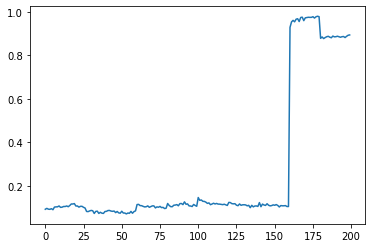

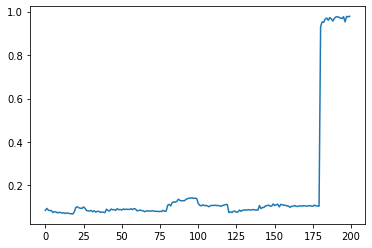

In [13]:
# fig, axes = plt.subplots()
for i in range(n_tasks):
    # axis.plot(test_accuracies[i])
    plt.figure(i)
    # plt.subplot(211)
    plt.plot(test_accuracies[i])

In [14]:
for i in range(n_tasks):
    print('Final accuracy for task {}: \n{}\n'.format(i, test_accuracies[i][-1]))

Final accuracy for task 0: 
0.5089

Final accuracy for task 1: 
0.6344

Final accuracy for task 2: 
0.6537

Final accuracy for task 3: 
0.7026

Final accuracy for task 4: 
0.8055

Final accuracy for task 5: 
0.7446

Final accuracy for task 6: 
0.7801

Final accuracy for task 7: 
0.9138

Final accuracy for task 8: 
0.8932

Final accuracy for task 9: 
0.9783

